In [1]:
from tensorflow import keras

In [4]:
import numpy as np

data = keras.datasets.cifar10.load_data()

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = data
X_train, X_val, y_train, y_val = X_train_full[:40000], X_train_full[40000:], y_train_full[:40000], y_train_full[40000:]

X_train.shape

(40000, 32, 32, 3)

In [6]:
from sklearn.preprocessing import StandardScaler

X_train_flat = X_train.reshape(-1, 32*32*3)
X_val_flat = X_val.reshape(-1, 32*32*3)
X_test_flat = X_test.reshape(-1, 32*32*3)

scaler = StandardScaler()
X_trains = scaler.fit_transform(X_train.reshape(-1, 32*32*3))
X_vals = scaler.transform(X_val.reshape(-1, 32*32*3))
X_tests = scaler.transform(X_test.reshape(-1, 32*32*3))

#X_trains, X_vals, X_tests = X_train / 255, X_val / 255, X_val / 255

In [5]:
dnn = keras.Sequential()

dnn.add(keras.layers.Flatten(input_shape=[32*32*3]))

for i in range(20):
    dnn.add(
        keras.layers.Dense(
            100, 
            activation=keras.activations.elu,
            kernel_initializer='he_normal'
        )
    )

dnn.add(keras.layers.Dense(10, activation='softmax'))

In [6]:
# Searching for the right learning rate

lr = 10**(-5)
CONST = 10**(6/50)  # exp_base10(log_base10(10^6) / 50)
losses = []

for i in range(50):
    lr = lr * CONST
    
    dnn.compile(
        loss='sparse_categorical_crossentropy',             
        optimizer=keras.optimizers.Nadam(learning_rate=lr),   
        metrics=['accuracy']                                 
    )
    
    history = dnn.fit(X_trains, y_train, epochs=1)
    losses.append(history.history['loss'][0])

1250/1250 [==============================] - 22s 11ms/step - loss: 933.1603 - accuracy: 0.1011


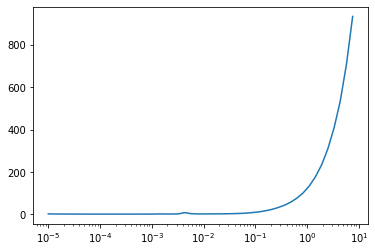

In [7]:
import matplotlib.pyplot as plt

plt.plot([10**(-5) * (CONST**i) for i in range(50)], np.nan_to_num(losses, nan=1000))
plt.xscale('log')

plt.show()  # good lr: 0.03 (10^-0.5 shooted up. / 10 = 10^-1.5 = 0.03)

# buuut, the first small spike happened at 10^-2.7 -> good lr: 0.0002

In [21]:
dnn = keras.Sequential()

dnn.add(keras.layers.Flatten(input_shape=[32*32*3]))

for i in range(20):
    dnn.add(
        keras.layers.Dense(
            100, 
            activation=keras.activations.elu,
            kernel_initializer='he_normal'
        )
    )

dnn.add(keras.layers.Dense(10, activation='softmax'))

dnn.compile(
    loss='sparse_categorical_crossentropy',             
    optimizer=keras.optimizers.Nadam(learning_rate=0.0002),   
    metrics=['accuracy']                                 
)

In [22]:
earlyStop_callback = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history = dnn.fit(X_trains, y_train, epochs=1000,  # there's early stopping, epochs can be very high
                  validation_data=(X_vals, y_val), callbacks=[earlyStop_callback])

Epoch 1/1000
1250/1250 [==============================] - 15s 10ms/step - loss: 1.9368 - accuracy: 0.3085 - val_loss: 1.7763 - val_accuracy: 0.3636
Epoch 2/1000
1250/1250 [==============================] - 11s 9ms/step - loss: 1.6534 - accuracy: 0.4042 - val_loss: 1.6145 - val_accuracy: 0.4202
Epoch 3/1000
1250/1250 [==============================] - 11s 9ms/step - loss: 1.5406 - accuracy: 0.4518 - val_loss: 1.5519 - val_accuracy: 0.4467
Epoch 4/1000
1250/1250 [==============================] - 11s 9ms/step - loss: 1.4588 - accuracy: 0.4772 - val_loss: 1.5547 - val_accuracy: 0.4511
Epoch 5/1000
1250/1250 [==============================] - 12s 10ms/step - loss: 1.3916 - accuracy: 0.5045 - val_loss: 1.5003 - val_accuracy: 0.4747
Epoch 6/1000
1250/1250 [==============================] - 13s 11ms/step - loss: 1.3265 - accuracy: 0.5292 - val_loss: 1.5261 - val_accuracy: 0.4640
Epoch 7/1000
1250/1250 [==============================] - 11s 9ms/step - loss: 1.2766 - accuracy: 0.5461 - val_loss

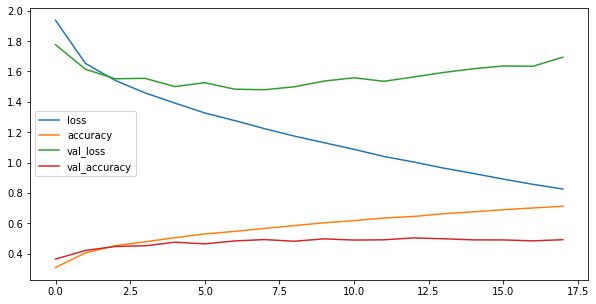

In [23]:
import pandas

pandas.DataFrame(history.history).plot(figsize=(10, 5))
plt.show()  # pretty bad. Best val_accuracy (with the minimum loss model) was around 48%

In [43]:
dnn.save('dnn_no_BN.h5')

# Batch normalization

In [16]:
# Since the net is very deep (it has 20 layers), the model is propably suffering from the
# vanishing gradients problem (the variance of the layers gets increasingly high the deeper
# you go, making the activation function - even the elu - saturate, eliminating the "slopes"
# in which gradient descent would act). 

# Let's try to solve it with batch normalization, which prevents saturation by normalizing the values
# received/sent by the activation functions.

In [45]:
dnn_batch = keras.Sequential()

dnn_batch.add(keras.layers.Flatten(input_shape=[32*32*3]))

for i in range(20):
    dnn_batch.add(keras.layers.BatchNormalization())  # BN before the activation function
    dnn_batch.add(
        keras.layers.Dense(
            100, 
            activation=keras.activations.elu,
            kernel_initializer='he_normal'
        )
    )

#dnn_batch.add(keras.layers.BatchNormalization())  # Softmax already does the job here
dnn_batch.add(keras.layers.Dense(10, activation='softmax', kernel_initializer='he_normal'))
# oopss... I didn't initilize the output layer properly in the previous rounds...

dnn_batch.compile(
    loss='sparse_categorical_crossentropy',             
    optimizer=keras.optimizers.Nadam(learning_rate=0.0002),   
    metrics=['accuracy']                                 
)

In [46]:
earlyStop_callback_batch = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history_batch = dnn_batch.fit(X_trains, y_train, epochs=1000, 
                              validation_data=(X_vals, y_val), callbacks=[earlyStop_callback_batch])

Epoch 1/1000
1250/1250 [==============================] - 23s 14ms/step - loss: 2.0479 - accuracy: 0.2734 - val_loss: 1.7912 - val_accuracy: 0.3612
Epoch 2/1000
1250/1250 [==============================] - 17s 14ms/step - loss: 1.7918 - accuracy: 0.3627 - val_loss: 1.7008 - val_accuracy: 0.4014
Epoch 3/1000
1250/1250 [==============================] - 17s 13ms/step - loss: 1.7090 - accuracy: 0.3900 - val_loss: 1.6261 - val_accuracy: 0.4207
Epoch 4/1000
1250/1250 [==============================] - 17s 13ms/step - loss: 1.6454 - accuracy: 0.4164 - val_loss: 1.5764 - val_accuracy: 0.4350
Epoch 5/1000
1250/1250 [==============================] - 17s 13ms/step - loss: 1.5997 - accuracy: 0.4331 - val_loss: 1.5375 - val_accuracy: 0.4569
Epoch 6/1000
1250/1250 [==============================] - 17s 13ms/step - loss: 1.5518 - accuracy: 0.4503 - val_loss: 1.5037 - val_accuracy: 0.4670
Epoch 7/1000
1250/1250 [==============================] - 17s 13ms/step - loss: 1.5144 - accuracy: 0.4644 - val_

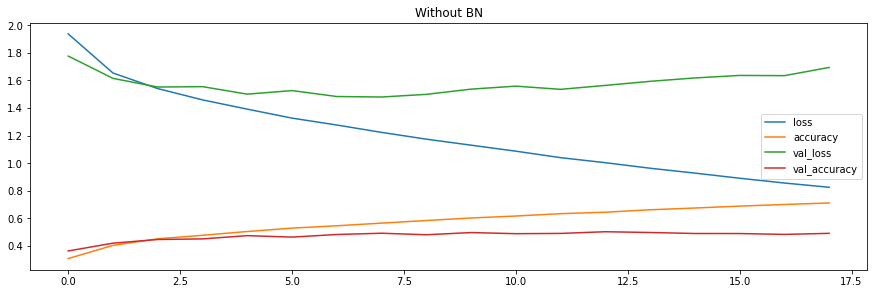

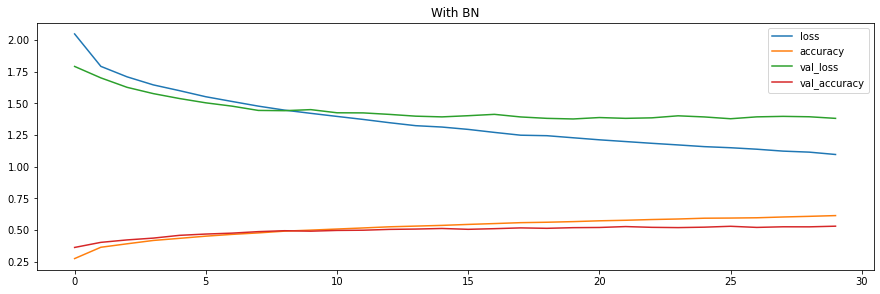

In [50]:
import pandas
import matplotlib.pyplot as plt

history_df = pandas.DataFrame(history.history)
history_batch_df = pandas.DataFrame(history_batch.history)

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.title('Without BN')
plt.plot(history_df)
plt.legend(history_df.columns)

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 2)
plt.title('With BN')
plt.plot(history_batch_df)
plt.legend(history_batch_df.columns)

plt.show()  # there was a slight improvement (from ~48% to ~52%)

In [48]:
# The batch normalization made the training considerably slower, since the number of iterations needed for conversion went
# up from 6 to 20 and each epoch took about 50% more time to be executed. However, the learning curve shows a lot less
# overfitting (the difference between the accuracy curve and the val_accuracy curve is lower) and a mildly better performance 
# (about 4% more accurate)

In [51]:
dnn_batch.save('dnn_with_BN.h5')

# Self normalization

In [52]:
# SELU (standardized ELU) is an optimizer derived from ELU that, in the right conditions, can self-normalize the model.

dnn_selu = keras.Sequential()

dnn_selu.add(keras.layers.Flatten(input_shape=[32*32*3]))

for i in range(20):
    dnn_selu.add(
        keras.layers.Dense(
            100, 
            activation=keras.activations.selu,
            kernel_initializer='lecun_normal'
        )
    )

dnn_selu.add(keras.layers.Dense(10, activation='softmax', kernel_initializer='lecun_normal'))

dnn_selu.compile(
    loss='sparse_categorical_crossentropy',             
    optimizer=keras.optimizers.Nadam(learning_rate=0.0002),   
    metrics=['accuracy']                                 
)

In [53]:
earlyStop_callback_selu = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history_selu = dnn_selu.fit(X_trains, y_train, epochs=1000, 
                            validation_data=(X_vals, y_val), callbacks=[earlyStop_callback_selu])

Epoch 1/1000
1250/1250 [==============================] - 15s 10ms/step - loss: 1.8258 - accuracy: 0.3438 - val_loss: 1.6941 - val_accuracy: 0.3991
Epoch 2/1000
1250/1250 [==============================] - 13s 10ms/step - loss: 1.6242 - accuracy: 0.4206 - val_loss: 1.6521 - val_accuracy: 0.4143
Epoch 3/1000
1250/1250 [==============================] - 12s 10ms/step - loss: 1.5282 - accuracy: 0.4538 - val_loss: 1.5731 - val_accuracy: 0.4484
Epoch 4/1000
1250/1250 [==============================] - 12s 10ms/step - loss: 1.4509 - accuracy: 0.4861 - val_loss: 1.5433 - val_accuracy: 0.4614
Epoch 5/1000
1250/1250 [==============================] - 12s 10ms/step - loss: 1.3894 - accuracy: 0.5083 - val_loss: 1.5156 - val_accuracy: 0.4675
Epoch 6/1000
1250/1250 [==============================] - 12s 10ms/step - loss: 1.3313 - accuracy: 0.5280 - val_loss: 1.4972 - val_accuracy: 0.4756
Epoch 7/1000
1250/1250 [==============================] - 12s 10ms/step - loss: 1.2767 - accuracy: 0.5461 - val_

In [54]:
# Accuracy was the same (~48%), as well as the number of iterations for convergence (~6)

In [55]:
dnn_selu.save("dnn_selu.h5")

# Regularization: Dropout

In [68]:
# This very deep net can be prone to overfitting. Let's try to normalize it with dropout 
# (alpha dropout, since we will use selu).

# Obs: dropout used before each dense layer since it affects the inputs of the previous layers

dnn_selu_d = keras.Sequential()

dnn_selu_d.add(keras.layers.Flatten(input_shape=[32*32*3]))

for i in range(20):
    #dnn_selu_d.add(keras.layers.AlphaDropout(rate=0.1))
    dnn_selu_d.add(
        keras.layers.Dense(
            100, 
            activation=keras.activations.selu,
            kernel_initializer='lecun_normal'
        )
    )

dnn_selu_d.add(keras.layers.AlphaDropout(rate=0.1))  # let's just use it in one layer. The regularization was too strong
dnn_selu_d.add(keras.layers.Dense(10, activation='softmax', kernel_initializer='lecun_normal'))

dnn_selu_d.compile(
    loss='sparse_categorical_crossentropy',             
    optimizer=keras.optimizers.Nadam(learning_rate=0.0002),   
    metrics=['accuracy']                                 
)

In [69]:
earlyStop_callback_selu_d = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history_selu_d = dnn_selu_d.fit(X_trains, y_train, epochs=1000, 
                                validation_data=(X_vals, y_val), callbacks=[earlyStop_callback_selu_d])

Epoch 1/1000
1250/1250 [==============================] - 15s 10ms/step - loss: 1.8741 - accuracy: 0.3331 - val_loss: 1.7114 - val_accuracy: 0.4018
Epoch 2/1000
1250/1250 [==============================] - 12s 10ms/step - loss: 1.6251 - accuracy: 0.4192 - val_loss: 1.6155 - val_accuracy: 0.4392
Epoch 3/1000
1250/1250 [==============================] - 12s 10ms/step - loss: 1.5159 - accuracy: 0.4609 - val_loss: 1.5946 - val_accuracy: 0.4563
Epoch 4/1000
1250/1250 [==============================] - 13s 10ms/step - loss: 1.4389 - accuracy: 0.4881 - val_loss: 1.5560 - val_accuracy: 0.4542
Epoch 5/1000
1250/1250 [==============================] - 12s 10ms/step - loss: 1.3793 - accuracy: 0.5128 - val_loss: 1.5380 - val_accuracy: 0.4719
Epoch 6/1000
1250/1250 [==============================] - 12s 10ms/step - loss: 1.3165 - accuracy: 0.5341 - val_loss: 1.5230 - val_accuracy: 0.4907
Epoch 7/1000
1250/1250 [==============================] - 12s 10ms/step - loss: 1.2693 - accuracy: 0.5520 - val_

In [103]:
# Checking accuracy of the final model since the val_loss of each dropped model can be missleading

print(list(np.argmax(dnn_selu_d.predict(X_vals), axis=1))[:40])
print([y_val[i, 0] for i in range(40)], '\n')

print('Acc:', np.mean(y_val[:, 0] == np.argmax(dnn_selu_d.predict(X_vals), axis=1)))

[1, 8, 5, 1, 2, 7, 4, 7, 8, 4, 5, 3, 0, 8, 7, 3, 6, 2, 0, 8, 2, 7, 2, 4, 8, 7, 7, 4, 3, 9, 7, 1, 4, 4, 1, 3, 4, 9, 4, 6]
[1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8, 2, 7, 0, 4, 1, 7, 7, 4, 4, 9, 9, 6, 2, 4, 1, 6, 4, 9, 6, 6] 

Acc: 0.4907


In [104]:
# The accuracy was slightly better and the train time was the same
# Let's now use a technique that resembles an emsembled learning model: the monte carlo dropout

y_probas = np.stack([dnn_selu_d(X_vals, training = True) for sample in range(100)])  
# calling the model is the same as the predict_proba method, but it allows the 
# dropout to remain active in the test stage (with training = True).
y_proba = y_probas.mean(axis = 0)

print('MC Acc:', np.mean(y_val[:, 0] == np.argmax(y_proba, axis=1)))

MC Acc: 0.4914


In [102]:
# The accuracy was slightly better, but it took a lot longer to run. In regards to accuracy, the MC dropout is not worth it

# Learning rate scheduling

In [127]:
# 1-cycle learning rate schedule: starts low, goes up, than goes down again

class OneCycleScheduler(keras.callbacks.Callback):
    
    def __init__(self, iterations, max_rate, max_m, start_rate=None, min_m=None, last_iterations=None, last_rate=None):
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_rate = last_rate or self.start_rate / 1000
        self.max_m = max_m
        self.min_m = min_m or (0.8 * max_m)
        
        self.iterations = iterations
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.iteration = 0
    
    def _interpolate(self, iter1, iter2, rate1, rate2, m1, m2):
        return ((rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1), \
               ((m2 - m1) * (self.iteration - iter1) / (iter2 - iter1) + m1)
    
    def on_epoch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate, m = self._interpolate(0, self.half_iteration, 
                                        self.start_rate, self.max_rate,
                                        self.max_m, self.min_m)
            
        elif self.iteration < 2 * self.half_iteration:
            rate, m = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                        self.max_rate, self.start_rate,
                                        self.min_m, self.max_m)
            
        else:
            rate, m = self._interpolate(2 * self.half_iteration, self.iterations,
                                        self.start_rate, self.last_rate,
                                        self.max_m, self.max_m)
        
        print(rate, m)
        
        keras.backend.set_value(self.model.optimizer.lr, rate)
        keras.backend.set_value(self.model.optimizer.beta_1, m)
        self.iteration += 1

In [128]:
dnn_selu_s = keras.Sequential()

dnn_selu_s.add(keras.layers.Flatten(input_shape=[32*32*3]))

for i in range(20):
    dnn_selu_s.add(
        keras.layers.Dense(
            100, 
            activation=keras.activations.selu,
            kernel_initializer='lecun_normal'
        )
    )

dnn_selu_s.add(keras.layers.Dense(10, activation='softmax', kernel_initializer='lecun_normal'))

dnn_selu_s.compile(
    loss='sparse_categorical_crossentropy',             
    optimizer=keras.optimizers.Nadam(learning_rate=0.0002),   
    metrics=['accuracy']                                 
)

In [129]:
oneCycle = OneCycleScheduler(15, 0.0002, 0.95)

history_selu_s = dnn_selu_s.fit(X_trains, y_train, epochs=15, 
                                validation_data=(X_vals, y_val), callbacks=[oneCycle])

Epoch 1/15
2e-05 0.95
1250/1250 [==============================] - 18s 12ms/step - loss: 1.9620 - accuracy: 0.2947 - val_loss: 1.8295 - val_accuracy: 0.3447
Epoch 2/15
5e-05 0.9183333333333333
1250/1250 [==============================] - 16s 12ms/step - loss: 1.7224 - accuracy: 0.3840 - val_loss: 1.6772 - val_accuracy: 0.4010
Epoch 3/15
8e-05 0.8866666666666666
1250/1250 [==============================] - 16s 13ms/step - loss: 1.6057 - accuracy: 0.4279 - val_loss: 1.6036 - val_accuracy: 0.4337
Epoch 4/15
0.00011 0.855
1250/1250 [==============================] - 16s 13ms/step - loss: 1.5393 - accuracy: 0.4529 - val_loss: 1.5811 - val_accuracy: 0.4400
Epoch 5/15
0.00014000000000000001 0.8233333333333334
1250/1250 [==============================] - 16s 13ms/step - loss: 1.4962 - accuracy: 0.4679 - val_loss: 1.5544 - val_accuracy: 0.4531
Epoch 6/15
0.00017 0.7916666666666666
1250/1250 [==============================] - 16s 13ms/step - loss: 1.4604 - accuracy: 0.4791 - val_loss: 1.5374 - v

In [ ]:
# from ~48% to ~51% (considering the one with the minimum val_loss). And decently faster than batch normalization!